# English to French translator

This notebook implements a translator based on NLP. We use an encoder based on a GRU layer to encode English into a hidden state, and then a decoder based on another GRU preceded by an Attention layer. 

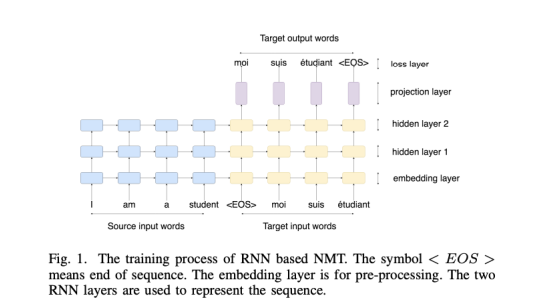

In [1]:
#from __future__ import unicode_literals, print_function, division
#from io import open
import unicodedata
import string
import re
import random
import time
import math
import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Define Language classes

In [2]:
SOS_token = 0 # starting token
EOS_token = 1 # ending token

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# read the files
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Only consider sentences shorter than MAX_LENGTH and starting with predefined prefixes

In [4]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return p if p[1].startswith(eng_prefixes) and len(p[0].split()) < MAX_LENGTH and len(p[1].split()) < MAX_LENGTH else None

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [5]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


In [6]:
example_pair = random.choice(pairs)
print(example_pair)

['tu es deux fois plus fort que moi .', 'you are twice as strong as me .']


## 2. Transform languages to tensors 

In [7]:
# Split a sentence by ' ' and return a list of the tokens (int ids) for each word
# Use word2index
def indexesFromSentence(lang, sentence):
    return [lang.word2index[w] for w in sentence.split(' ')]

# Call the above on a sentence
# After calling, add the EOS_token (int id) to the gotten list
# Return a tensor, but reshape it so it's dimensions (-1, 1)
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.as_tensor(indexes).view(-1, 1)

# For a source, target pair, call the above. Return a tuple of 2 tensors, one input_tensor and another an output_tensor
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [8]:
print('input sentence in French: ', example_pair[0])
print('input tensor: \n', tensorFromSentence(input_lang, example_pair[0]))

print('output sentence in English: ', example_pair[1])
print('output tensor: \n', tensorFromSentence(output_lang, example_pair[1]))

input sentence in French:  tu es deux fois plus fort que moi .
input tensor: 
 tensor([[ 210],
        [ 211],
        [1237],
        [2080],
        [ 152],
        [ 188],
        [ 902],
        [  42],
        [   5],
        [   1]])
output sentence in English:  you are twice as strong as me .
output tensor: 
 tensor([[ 129],
        [ 124],
        [1073],
        [ 890],
        [ 120],
        [ 890],
        [ 343],
        [   4],
        [   1]])


## 3. Define encoder and decoder

In [9]:
# French -> hidden

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = self.embedding = nn.Embedding(
            input_size,
            hidden_size
        )
        # Make the encoder a GRU and also make it bidirectional.
        # Let it have 1 layers in the vertical direction.
        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            bidirectional=False,
            batch_first=True
        )

    def forward(self, input, hidden):
        # Get the embeddings and reshape to be (1, 1, -1)
        embedded = self.embedding(input)
        output = embedded.view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [10]:
# hidden -> English

class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttentionDecoderRNN, self).__init__()
        
        # H
        self.hidden_size = hidden_size
        
        # vocab_size
        self.output_size = output_size
        
        self.dropout_p = dropout_p
        self.max_length = max_length

        # Intialize the embedding going from vocab_size to H
        self.embedding = nn.Embedding(
            output_size,
            hidden_size
        ) 
        
        # Initialize the attention projection as a Linear layer from 2*H to self.max_length
        self.attention_projection = nn.Linear(2*hidden_size, max_length)
        
        # Initialize the output projection as a Linear layer from 2*H -> H (this is before we project to the vocab_size)
        self.output_projection = nn.Linear(2*hidden_size, hidden_size)
        
        # Intialize a Dropout layer with self.dropout_p probability
        self.dropout = nn.Dropout(p=dropout_p)
        
        # Make the GRU be unidirectional and also with 1 hidden layer
        # Input and hidden data each have a dimension of H
        self.gru = self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True
        )
        
        # Intialize a Linear layer going from H to vocab_size
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        # (1, 1, H)
        embedded = self.embedding(input).view(1, 1, -1)
        
        # Pass embedding through the dropout layer
        embedded = self.dropout(embedded)

        # (1, 2*H)
        # Concatenate yt and kt to get a vector (y_t, k_{t-1})
        embedded_hidden = torch.cat((embedded[0], hidden), 1)
        
        # (1, MAX_LENGTH)
        # Project the above vector to get a vector mixing the elements of the above
        # This vector will be used to get attention scores with all the encoder embeddings
        # Here, the scores are scores = W_a[y_{t}, k_{t-1}] + b_a where W_a an b_a are in self.attention_projection
        # You can have other formats here, but the one above is enough for this problem
        attention_scores = self.attention_projection(embedded_hidden)
        
        # (1, MAX_LENGTH)
        # Get the attention weights from the scores
        # I.e. get probabilistic from the above scores
        attention_weights = nn.Softmax(dim=1)(attention_scores)
        
        # (1, 1, H)
        # Multiply the weights by the hidden states (h_1, h_2, .., h_{T_x}) of the encoder
        # This should be a vector of the above dimensions, so you'll need unsqueeze
        # One way to do this is using torch.bmm on these unsqueezed vectors
        # This will be the at vector that mixed the encoder's hidden representations; "c_{t}"" in lecture
        attention_context = torch.bmm(attention_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        # (1, 2*H)
        # Concatenate (yt, at) to get a vector that we will use to predict the output
        output = torch.cat((embedded[0], attention_context[0]), 1)
        
        # (1, 1, H)
        # Project the above vector into a new vector we'll use to predict with
        # unsqueeze(0) the result to get the right dimensions
        output = self.output_projection(output).unsqueeze(0)

        # (1, H)
        # Pass through ReLU
        output = nn.ReLU()(output).squeeze(0)
        
        # (1, H) and (1, H)
        # Pass the output and hidden through the GRU. Note that we apply attention before we pass into the GRU
        # The input ("output" vector) has attentional information in it
        output, hidden = self.gru(output, hidden)

        # (1, vocab_size)
        # Either apply log_softmax to output or leave it alone
        # This will have you use the NLLLoss or the CrossEntropyLoss
        output = self.out(output)
        return output, hidden, attention_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 4. Training

In [11]:
teacher_forcing_ratio = 0.5

# train on 1 (input, output) pair
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    # Initialize the hidden states
    encoder_hidden = encoder.initHidden()

    # Reset the optimizer gradients to 0
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Initialize the encoder outputs - these are used to store the vector's we'll use to get attention scores
    # This should be (max_length, H) and all zeros to start
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    # Pass the data through the encoder
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Save the encoder output into "encoder_outputs"
        encoder_outputs[ei] = encoder_output

    # Initialize the decoder input to the SOS_token
    decoder_input = torch.as_tensor([SOS_token])

    # Initialize the hidden states of the decoder with the hidden states of the encoder
    decoder_hidden = encoder_hidden.clone()[0]

    # For this pair, use teacher forcing with 50% probability, else don't
    use_teacher_forcing = np.random.binomial(1, teacher_forcing_ratio)
    use_teacher_forcing=0
    target_length_used = 0

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        
        target_length_used = target_length
        
        for di in range(target_length):
            # Push decoder_input, decoder_hidden, and decoder_cell through the decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(input=decoder_output[0], target=target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            # Push decoder_input, decoder_hidden, and decoder_cell through the decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Get greedy top probability prediction
            topv, topi = torch.max(decoder_output), torch.argmax(decoder_output)
            decoder_input = torch.as_tensor([topi.detach()])  # detach from history as input
            
            # Get the loss
            loss += criterion(input=decoder_output[0], target=target_tensor[di][0])
            
            # Update the target_length_used
            target_length_used += 1
            
            # If the EOS_token was generated, exit
            if topi == EOS_token:
                break

    # Collect gradients
    loss.backward()

    # Do a step; do this both for the encoder and the decoder
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length_used

In [12]:
# Helper functions used to time the optimizations
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))





########################################### Global training function ########################################



def trainIters(encoder, decoder, n_iters, print_every=1000, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    # Initialize the encoder and decoder optimizers with the above learning rate
    encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
    
    # Get n_iters training pairs
    # In this example, we are effectively doing SGD with batch size 1
    training_pairs = random.choices(pairs, k=n_iters)
    
    # The loss; either NLLLoss if you use log sigmoids or CrossEntropyLoss if you use logits
    criterion = nn.CrossEntropyLoss()

    for it in range(1, n_iters + 1):
        training_pair = training_pairs[it - 1]
        input_tensor = tensorsFromPair(training_pair)[0]
        target_tensor = tensorsFromPair(training_pair)[1]

        # Train on the input, target pair
        loss =  train(
            input_tensor,
            target_tensor,
            encoder,
            decoder,
            encoder_optimizer,
            decoder_optimizer,
            criterion
        )
        
        # Update the total loss and the plot loss
        # We can plot and print at different granularities
        print_loss_total += loss
        plot_loss_total += loss

        if it % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, it / n_iters),
                                         it, it / n_iters * 100, print_loss_avg))

In [13]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttentionDecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder, decoder, 75000, print_every=5000)

6m 30s (- 91m 1s) (5000 6%) 3.2615
13m 50s (- 89m 57s) (10000 13%) 2.5382
21m 11s (- 84m 46s) (15000 20%) 2.2023
27m 40s (- 76m 7s) (20000 26%) 1.9102
34m 47s (- 69m 34s) (25000 33%) 1.6782
41m 33s (- 62m 20s) (30000 40%) 1.4855
47m 44s (- 54m 34s) (35000 46%) 1.3492
53m 58s (- 47m 13s) (40000 53%) 1.2154
60m 35s (- 40m 23s) (45000 60%) 1.0867
67m 43s (- 33m 51s) (50000 66%) 0.9580
74m 47s (- 27m 11s) (55000 73%) 0.9168
81m 47s (- 20m 26s) (60000 80%) 0.8545
87m 58s (- 13m 32s) (65000 86%) 0.7754
94m 9s (- 6m 43s) (70000 93%) 0.6775
100m 58s (- 0m 0s) (75000 100%) 0.6186


## 5. Evaluate translation

In [14]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        # Transform the input sentence into a tensor
        input_tensor = tensorFromSentence(input_lang, sentence)
        
        input_length = input_tensor.size()[0]
        
        # Initilize the hidden and cell states of the LSTM
        encoder_hidden = encoder.initHidden()

        # Initialize the encoder outputs as in train
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Run the data through the LSTM word by word manually
        # At each step, feed in the input, the hidden state, and the cell state and calture the new hidden / cell states
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] = encoder_output

        # Initialize the decoder input with a SOS_token
        decoder_input =  torch.as_tensor([SOS_token])  # SOS

        # Initialize the decoder hidden state with the encoder's hidden state
        decoder_hidden = encoder_hidden.clone()[0]

        # Initialize the decoded words and a matrix of T by T length which will store the attention weights
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # Pass the data through the decoder
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Save the attention matrix above - you might want to look at this later to debug
            decoder_attentions[di] = decoder_attention
            # Get the top (1) decoder output as use this as the next input
            topv, topi = torch.max(decoder_output), torch.argmax(decoder_output)
            
            if topi == EOS_token:
                decoded_words.append('EOS')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])         

            # Save the token above as the next input
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [15]:
# Translation of example pair
print("Input sentence in French: ", example_pair[0])

print("Candidate translation: ", ' '.join(evaluate(encoder, decoder, example_pair[0])[0][:-1]))
print("Reference translation: ", example_pair[1])

Input sentence in French:  tu es deux fois plus fort que moi .
Candidate translation:  you are twice as strong as i .
Reference translation:  you are twice as strong as me .


In [16]:
# Translation of other sentence with predefined prefix
input_sentence = "je suis tres belle"

print("Input sentence in French: ", input_sentence)

print("Candidate translation: ", ' '.join(evaluate(encoder, decoder, input_sentence)[0][:-1]))
print("Reference translation: ", "i am very beautiful .")

Input sentence in French:  je suis tres belle
Candidate translation:  i m very beautiful as i .
Reference translation:  i am very beautiful .


In [17]:
# Translation of other sentence without predefined prefix
input_sentence = "le batiment est grand ."

print("Input sentence in French: ", input_sentence)

print("Candidate translation: ", ' '.join(evaluate(encoder, decoder, input_sentence)[0][:-1]))
print("Reference translation: ", "the building is tall .")

Input sentence in French:  le batiment est grand .
Candidate translation:  he is his big .
Reference translation:  the building is tall .


## 6. Compute BLEU score

In [18]:
from nltk.translate.bleu_score import sentence_bleu

def evaluateRandomly(encoder, decoder, n=7500, debug=False):
    bleu_scores = []
    for i in range(n):
        pair = random.choice(pairs)
        if debug:
            print('French Original: ', pair[0])
            print('English Reference: ', pair[1])
        # Leave out the EOS symbol
        output_words, _ = evaluate(encoder, decoder, pair[0])
        
        # If EOS is at the end, remove it from output_words
        output_words = output_words[:-1] if output_words[-1]=='EOS' else output_words
                            
        output_sentence = ' '.join(output_words)
        # Use pair[1] as te refernce and get the BLEU score based on just 2 grams with 50% weight each
        score = sentence_bleu([pair[1].split()], output_sentence.split(), weights=(1/2, 1/2, 0, 0))
        
        # Append the BLEU score to the list of BLEU scores
        bleu_scores.append(100*score)
        if debug:
            print('Candidate Translation: ', output_sentence)
            print('BLEU: ', score)
            print('')
    print('The mean BLEU score is: ', np.mean(bleu_scores))

In [19]:
evaluateRandomly(encoder, decoder, n=7500, debug=False)

C:\Users\dell\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\dell\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\dell\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.

The mean BLEU score is:  78.12093622449903
